<a href="https://colab.research.google.com/github/divyachavan519-bot/Neuro-Aid/blob/main/NeuroAid_Backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# ============================================================================
# SECTION 1: INSTALL AND IMPORT DEPENDENCIES
# ============================================================================

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

TensorFlow version: 2.19.0
GPU Available: True


In [ ]:
from google.colab import files
print("Please upload your dataset ZIP file:")
uploaded = files.upload()

# Extract the uploaded zip file
zip_filename = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('.')

print("Dataset extracted successfully!")

Please upload your dataset ZIP file:


Saving dataset 3.zip to dataset 3.zip
Dataset extracted successfully!



DIAGNOSING DATASET PATHS
Contents of current directory:
- .config
- best_model.h5
- sample_dataset.png
- val_0000.png
- __MACOSX
- dataset.zip
- dataset (2).zip
- dataset
- dataset (1).zip
- val_0000.txt
- dataset 3.zip
- dataset 3
- sample_data

Looking for base directories: ['dataset 3', 'dataset']

Detected primary extracted base directory: 'dataset 3'
Contents of 'dataset 3':
  - .DS_Store
  - Val 
    Contents of 'Val ': dataset 3/Val  -> ['.DS_Store', 'val_image', 'val_label']
  - Training
    Contents of 'Training': dataset 3/Training -> ['.DS_Store', 'train label', 'train image']

Proposed paths:
  train_img_path: dataset 3/Training/train image
  train_label_path: dataset 3/Training/train label
  val_img_path: dataset 3/Val /val_image
  val_label_path: dataset 3/Val /val_label

LOADING TRAINING DATA
Loading from: dataset 3/Training/train image
Labels from: dataset 3/Training/train label
Found 1873 images
Successfully loaded 1873 images

LOADING VALIDATION DATA
Loading from: da

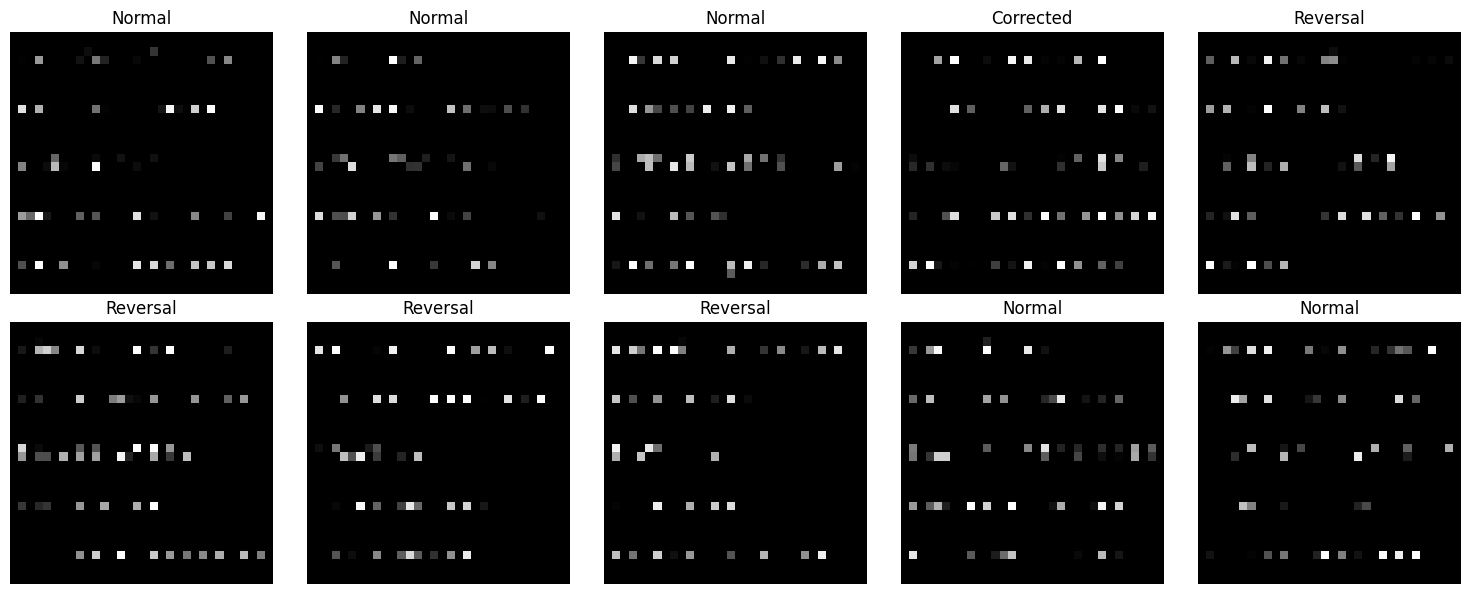

In [ ]:
def load_images_and_labels_yolo(image_folder, label_folder, target_size=(32, 32)):
    import os # Added to ensure os module integrity
    import cv2 # Ensure cv2 is available locally if needed
    from collections import Counter # Ensure Counter is available locally
    """
    Load images and labels from YOLO format
    YOLO format: Each .txt file contains class_id and bounding box coordinates
    We only need the class_id (first number in each line)
    """
    images = []
    labels = []
    filenames = []

    print("Loading from:", image_folder)
    print("Labels from:", label_folder)

    # Get all image files
    if not os.path.exists(image_folder):
        raise FileNotFoundError(f"Image folder not found: {image_folder}")
    image_files = [f for f in os.listdir(image_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    print("Found", len(image_files), "images")

    loaded_count = 0

    for img_file in sorted(image_files):
        # Get corresponding label file
        base_name = os.path.splitext(img_file)[0]
        label_file = base_name + '.txt'

        img_path = os.path.join(image_folder, img_file)
        label_path = os.path.join(label_folder, label_file)

        # Check if label file exists
        if not os.path.exists(label_path):
            print("Warning: No label for", img_file)
            continue

        try:
            # Read image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print("Failed to load:", img_file)
                continue

            # Resize to 32x32 (as per paper)
            img = cv2.resize(img, target_size)

            # Normalize to [0, 1]
            img = img.astype('float32') / 255.0

            # Read labels (YOLO format - multiple lines possible, each with class_id)
            # Assign the most frequent class_id found in the file to the image.
            class_ids_in_file = []
            with open(label_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        current_class_id = int(line.split()[0])
                        class_ids_in_file.append(current_class_id)

            if class_ids_in_file:
                # Count occurrences of each class_id and find the most frequent
                # from collections import Counter # Moved to function top
                most_common_class = Counter(class_ids_in_file).most_common(1)[0][0]

                images.append(img)
                labels.append(most_common_class)
                filenames.append(img_file)
                loaded_count += 1
            else:
                print("Warning: No valid class ID found in", label_file)

        except Exception as e:
            print("Error loading", img_file, ":", e)

    print("Successfully loaded", loaded_count, "images")

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Reshape for CNN (add channel dimension)
    if len(images) > 0:
        images = images.reshape(-1, 32, 32, 1)

    return images, labels, filenames

# Define your dataset paths - these will be dynamically determined
train_img_path = None
train_label_path = None
val_img_path = None
val_label_path = None

print("\n" + "="*50)
print("DIAGNOSING DATASET PATHS")
print("="*50)

# Ensure zip_filename is available (from previous cell execution)
# If running this cell independently, 'zip_filename' might not be defined.
# For robustness, we assume it's 'dataset 3.zip' if not found.
if 'zip_filename' not in locals() and 'zip_filename' not in globals():
    print("Warning: 'zip_filename' variable not found, assuming 'dataset 3.zip'.")
    zip_filename = 'dataset 3.zip'

print("Contents of current directory:")
for item in os.listdir('.'):
    print(f"- {item}")

# Step 1: Find the top-level extracted directory (e.g., 'dataset 3' or 'dataset')
extracted_base_dir = None

possible_base_names = [zip_filename.replace('.zip', '')]
if 'dataset' not in possible_base_names:
    possible_base_names.append('dataset')

print(f"\nLooking for base directories: {possible_base_names}")

for name in possible_base_names:
    if os.path.isdir(name):
        extracted_base_dir = name
        break

if extracted_base_dir:
    print(f"\nDetected primary extracted base directory: '{extracted_base_dir}'")
    print(f"Contents of '{extracted_base_dir}':")
    for item in os.listdir(extracted_base_dir):
        print(f"  - {item}")
        if os.path.isdir(os.path.join(extracted_base_dir, item)):
            print(f"    Contents of '{item}': {os.path.join(extracted_base_dir, item)} -> {os.listdir(os.path.join(extracted_base_dir, item))}")

    # Step 2: Determine the actual dataset root (it might be nested)
    dataset_root = extracted_base_dir
    if 'dataset' in os.listdir(extracted_base_dir) and os.path.isdir(os.path.join(extracted_base_dir, 'dataset')):
        dataset_root = os.path.join(extracted_base_dir, 'dataset')
        print(f"Detected inner 'dataset' folder, setting dataset root to: '{dataset_root}'")
        print(f"Contents of '{dataset_root}':")
        for item in os.listdir(dataset_root):
            print(f"  - {item}")
            if os.path.isdir(os.path.join(dataset_root, item)):
                print(f"    Contents of '{item}': {os.path.join(dataset_root, item)} -> {os.listdir(os.path.join(dataset_root, item))}")

    # Step 3: Construct paths based on the identified dataset_root
    train_img_path = os.path.join(dataset_root, 'Training', 'train image')
    train_label_path = os.path.join(dataset_root, 'Training', 'train label')
    val_img_path = os.path.join(dataset_root, 'Val ', 'val_image') # Corrected: Added space after 'Val'
    val_label_path = os.path.join(dataset_root, 'Val ', 'val_label') # Corrected: Added space after 'Val'

    print(f"\nProposed paths:")
    print(f"  train_img_path: {train_img_path}")
    print(f"  train_label_path: {train_label_path}")
    print(f"  val_img_path: {val_img_path}")
    print(f"  val_label_path: {val_label_path}")

    # Verify if these paths exist before proceeding
    all_paths_exist = True
    if not os.path.exists(train_img_path):
        print(f"Error: Training image path '{train_img_path}' does not exist. Please check your dataset structure.")
        all_paths_exist = False
    if not os.path.exists(train_label_path):
        print(f"Error: Training label path '{train_label_path}' does not exist. Please check your dataset structure.")
        all_paths_exist = False
    if not os.path.exists(val_img_path):
        print(f"Error: Validation image path '{val_img_path}' does not exist. Please check your dataset structure.")
        all_paths_exist = False
    if not os.path.exists(val_label_path):
        print(f"Error: Validation label path '{val_label_path}' does not exist. Please check your dataset structure.")
        all_paths_exist = False

    if not all_paths_exist:
        print("\n" + "="*50)
        print("WARNING: SOME PROPOSED PATHS DO NOT EXIST.")
        print("Please manually inspect the output above and correct the path definitions if necessary.")
        print("Execution will attempt to proceed, but expect FileNotFoundError if paths are wrong.")
        print("="*50)

else:
    print(f"Error: No extracted directory matching '{zip_filename.replace('.zip', '')}' or 'dataset' found.")
    print("Please ensure your uploaded zip file extracted correctly and check its top-level folder name.")
    print("\n" + "="*50)
    print("FATAL ERROR: COULD NOT DETERMINE VALID DATASET PATHS")
    print("Execution will stop here as data cannot be loaded.")
    print("="*50)
    import sys
    sys.exit(1)


print("\n" + "="*50)
print("LOADING TRAINING DATA")
print("="*50)
X_train, y_train, train_files = load_images_and_labels_yolo(train_img_path, train_label_path)

print("\n" + "="*50)
print("LOADING VALIDATION DATA")
print("="*50)
X_val, y_val, val_files = load_images_and_labels_yolo(val_img_path, val_label_path)

# --- Start of new diagnostic code ---
print("\n" + "="*50)
print("INSPECTING RAW LABEL FILES FOR CLASS DISTRIBUTION")
print("="*50)

def inspect_labels(label_folder):
    class_counts = {}
    if not os.path.exists(label_folder):
        print(f"Label folder not found: {label_folder}")
        return class_counts

    label_files = [f for f in os.listdir(label_folder) if f.lower().endswith('.txt')]
    print(f"Found {len(label_files)} label files in {label_folder}")

    for label_file in label_files:
        label_path = os.path.join(label_folder, label_file)
        try:
            with open(label_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line:
                        class_id = int(line.split()[0])
                        class_counts[class_id] = class_counts.get(class_id, 0) + 1
        except Exception as e:
            print(f"Error reading label file {label_file}: {e}")
    return class_counts

print("\nTraining Label Files Class Distribution:")
train_label_counts = inspect_labels(train_label_path)
print(train_label_counts)

print("\nValidation Label Files Class Distribution:")
val_label_counts = inspect_labels(val_label_path)
print(val_label_counts)
# --- End of new diagnostic code ---


print("\n" + "="*50)
print("DATASET SUMMARY")
print("="*50)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)
print("\nClass distribution in training:")
print("  Class 0 (Normal):" + str(np.sum(y_train == 0)))
print("  Class 1 (Reversal):" + str(np.sum(y_train == 1)))
print("  Class 2 (Corrected):" + str(np.sum(y_train == 2)))
print("\nClass distribution in validation:")
print("  Class 0 (Normal):" + str(np.sum(y_val == 0)))
print("  Class 1 (Reversal):" + str(np.sum(y_val == 1)))
print("  Class 2 (Corrected):" + str(np.sum(y_val == 2)))

# Visualize sample images
print("\nVisualizing sample images...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

class_names = ['Normal', 'Reversal', 'Corrected']
for i in range(10):
    idx = np.random.randint(0, len(X_train))
    axes[i].imshow(X_train[idx].reshape(32, 32), cmap='gray')
    axes[i].set_title(class_names[y_train[idx]])
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('sample_dataset.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# === Inspect a specific label file ===
label_file_to_inspect = "/content/val_0000.txt" # @param {type:"string"}

if os.path.exists(label_file_to_inspect):
    print(f"Content of {label_file_to_inspect}:")
    with open(label_file_to_inspect, 'r') as f:
        content = f.read()
        print(content)
        # Also try to parse the class ID for quick check
        first_line = content.strip().split('\n')[0]
        if first_line:
            try:
                class_id = int(first_line.split()[0])
                print(f"Detected class ID in the first line: {class_id}")
            except (ValueError, IndexError):
                print("Could not parse class ID from the first line.")
        else:
            print("Label file is empty or first line is blank.")
else:
    print(f"Error: Label file not found at {label_file_to_inspect}")
    print("Please check the path and make sure the file exists.")

Content of /content/val_0000.txt:
0 0.040625 0.100000 0.050000 0.050000
1 0.098437 0.100000 0.050000 0.050000
2 0.156250 0.100000 0.050000 0.050000
0 0.214062 0.100000 0.050000 0.050000
1 0.318750 0.100000 0.050000 0.050000
2 0.376563 0.100000 0.050000 0.050000
0 0.434375 0.100000 0.050000 0.050000
1 0.492188 0.100000 0.050000 0.050000
2 0.596875 0.100000 0.050000 0.050000
0 0.654687 0.100000 0.050000 0.050000
1 0.712500 0.100000 0.050000 0.050000
2 0.040625 0.300000 0.050000 0.050000
0 0.098437 0.300000 0.050000 0.050000
1 0.203125 0.300000 0.050000 0.050000
2 0.260937 0.300000 0.050000 0.050000
0 0.318750 0.300000 0.050000 0.050000
1 0.376563 0.300000 0.050000 0.050000
2 0.481250 0.300000 0.050000 0.050000
0 0.539062 0.300000 0.050000 0.050000
1 0.596875 0.300000 0.050000 0.050000
2 0.701562 0.300000 0.050000 0.050000
0 0.759375 0.300000 0.050000 0.050000
1 0.040625 0.500000 0.050000 0.050000
2 0.098437 0.500000 0.050000 0.050000
0 0.203125 0.500000 0.050000 0.050000
1 0.260937 0.500

In [ ]:
# ============================================================================
# # SECTION 4: MODIFIED LeNet-5 CNN ARCHITECTURE
# ============================================================================

def create_modified_lenet5(input_shape=(32, 32, 1), num_classes=3):
    """
    Modified LeNet-5 based on research paper
    Modifications:
    - Max pooling instead of average pooling
    - Batch normalization after each conv layer
    - Dropout 0.1 after 3rd conv layer
    - Swish activation
    - Adam optimizer
    """

    def swish(x):
        return x * tf.nn.sigmoid(x)

    model = models.Sequential([
        layers.Input(shape=input_shape),

        # C1: First Conv Layer
        layers.Conv2D(6, kernel_size=(5, 5), activation=swish, padding='same', name='C1'),
        layers.BatchNormalization(name='BN1'),

        # S2: First Pooling
        layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='S2'),

        # C3: Second Conv Layer
        layers.Conv2D(16, kernel_size=(5, 5), activation=swish, padding='valid', name='C3'),
        layers.BatchNormalization(name='BN2'),

        # S4: Second Pooling
        layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='S4'),

        # C5: Third Conv Layer
        layers.Conv2D(120, kernel_size=(5, 5), activation=swish, padding='valid', name='C5'),
        layers.BatchNormalization(name='BN3'),

        # Dropout
        layers.Dropout(0.1, name='Dropout'),

        # Flatten
        layers.Flatten(name='Flatten'),

        # F6: Fully Connected
        layers.Dense(84, activation=swish, name='F6'),

        # Output
        layers.Dense(num_classes, activation='softmax', name='Output')
    ])

    return model

# Create and compile model
model = create_modified_lenet5(input_shape=(32, 32, 1), num_classes=3)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
model.summary()


MODEL ARCHITECTURE


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 32, 32, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1 (BatchNormalization)        │ (None, 32, 32, 6)      │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (MaxPooling2D)               │ (None, 16, 16, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2 (BatchNormalization)        │ (None, 12, 12, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (MaxPooling2D)               │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Conv2D)                     │ (None, 2, 2, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3 (BatchNormalization)        │ (None, 2, 2, 120)      │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 2, 2, 120)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        40,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,919 (359.06 KB)

 Trainable params: 91,635 (357.95 KB)

 Non-trainable params: 284 (1.11 KB)

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("\n" + "="*50)
print("TRAINING MODEL")
print("="*50)

EPOCHS = 35
BATCH_SIZE = 32

# --- Start of modifications for class weighting ---
# Calculate class weights for imbalanced datasets
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
# Convert class_weights to a dictionary for Keras
class_weights_dict = dict(enumerate(class_weights))
print(f"Calculated Class Weights: {class_weights_dict}")
# --- End of modifications for class weighting ---

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights_dict, # Apply class weights here
    verbose=1
)


TRAINING MODEL
Calculated Class Weights: {0: np.float64(0.4600835175632523), 1: np.float64(1.384331116038433), 2: np.float64(9.605128205128205)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6042 - loss: 1.6386
Epoch 1: val_accuracy improved from -inf to 0.73210, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.6028 - loss: 1.6377 - val_accuracy: 0.7321 - val_loss: 0.7254 - learning_rate: 1.2500e-04
Epoch 2/35
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3844 - loss: 1.2569
Epoch 2: val_accuracy did not improve from 0.73210
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3844 - loss: 1.2569 - val_accuracy: 0.7321 - val_loss: 0.6794 - learning_rate: 1.2500e-04
Epoch 3/35
58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3429 - loss: 1.1810
Epoch 3: val_accuracy did not improve from 0.73210
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3434 - loss: 1.1844 - val_accuracy: 0.7321 - val_loss: 0.6990 - learning_rate: 1.2500e-04
Epoch 4/35
57/59 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3352 - loss: 1.1309
Epoch 4: val_accuracy did not improve from 0.73210
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3366 - loss: 1.1319 - val_accuracy: 0.7321 - val_loss: 0.7232 - learning_rate: 1.2500e-04
Epoch 5/35
57/59


FINAL EVALUATION

Validation Loss: 0.6953
Validation Accuracy: 73.21 %

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.73      1.00      0.85       634
    Reversal       0.00      0.00      0.00       204
   Corrected       0.00      0.00      0.00        28

    accuracy                           0.73       866
   macro avg       0.24      0.33      0.28       866
weighted avg       0.54      0.73      0.62       866


Per-Class Accuracy:
  Normal: 1.0
  Reversal: 0.0
  Corrected: 0.0

Confusion Matrix:
[[634   0   0]
 [204   0   0]
 [ 28   0   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


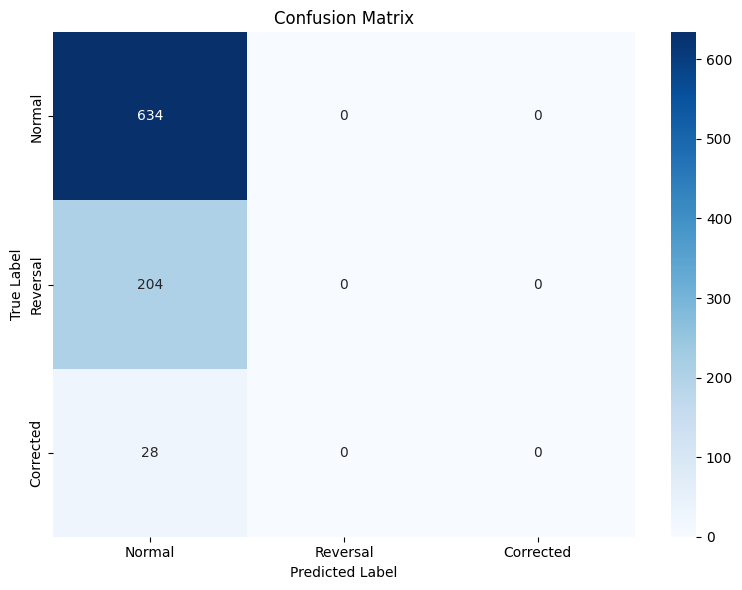

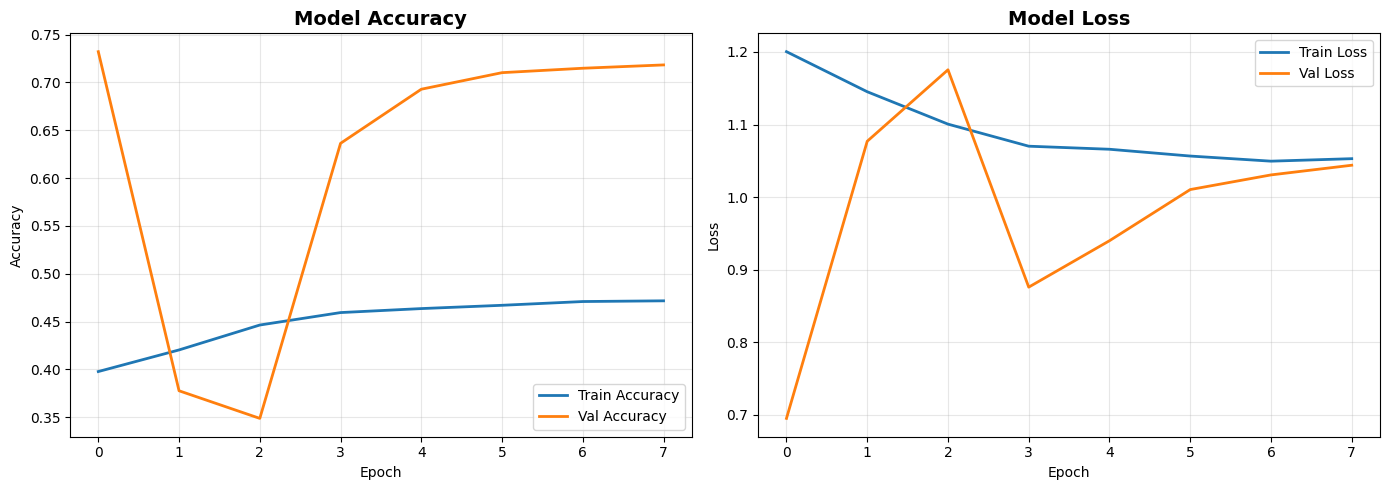

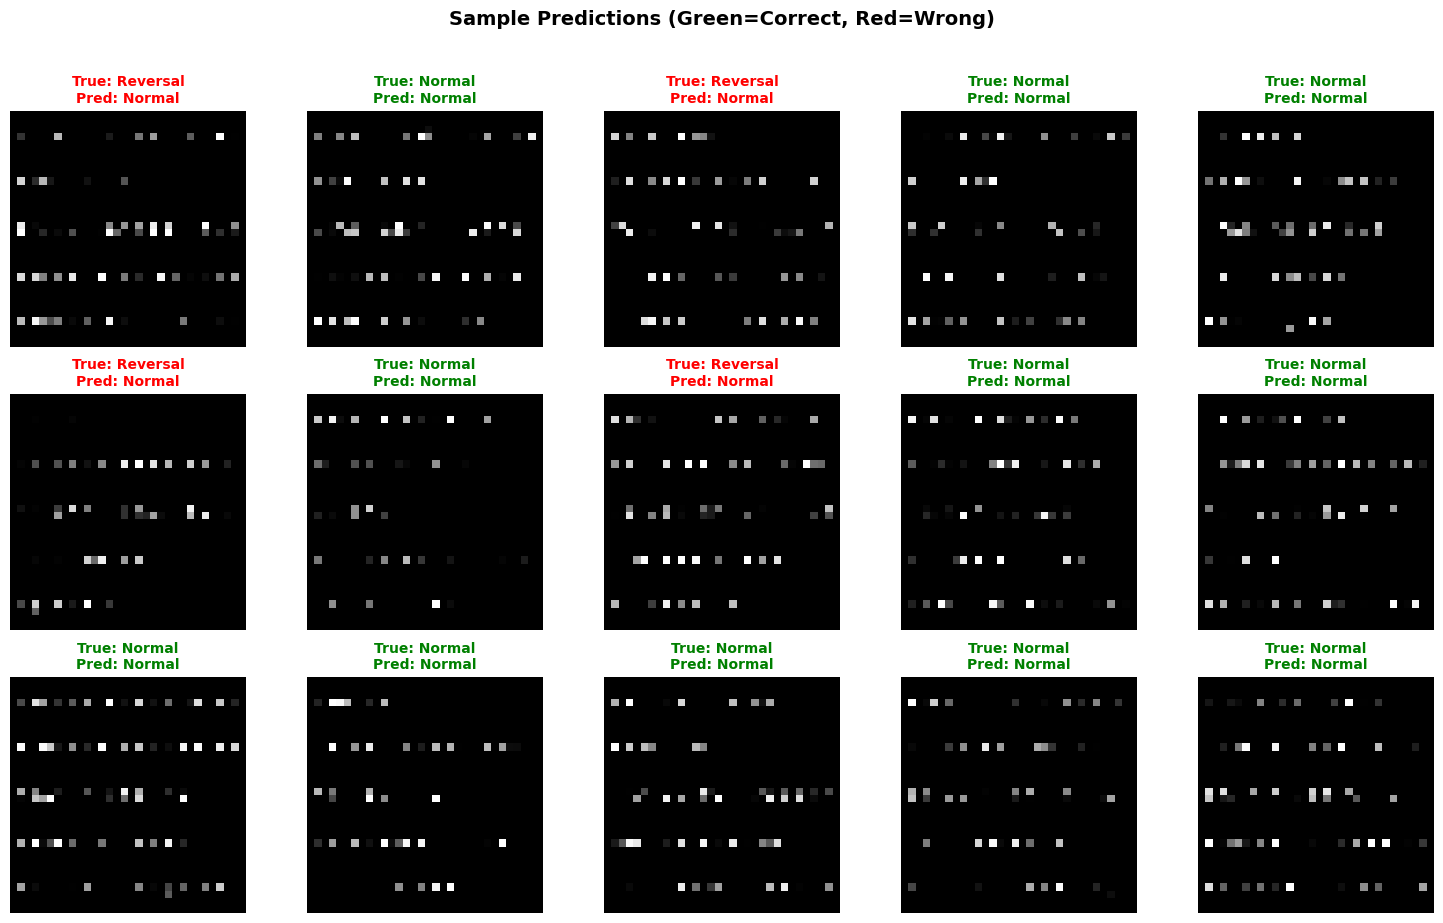


SAVING MODEL
Model saved as: dyslexia_cnn_model.h5



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TRAINING COMPLETE!
Final Validation Accuracy: 73.21 %
Target: 85-90% | Status: Keep tuning...


In [ ]:
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

# Load best weights
model.load_weights('best_model.h5')

# Evaluate
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print("\nValidation Loss:", round(val_loss, 4))
print("Validation Accuracy:", round(val_accuracy*100, 2), "%")

# Predictions
y_pred = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_val, y_pred_classes, target_names=class_names))

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    mask = y_val == i
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_val[mask], y_pred_classes[mask])
        print("  " + class_name + ":", round(class_acc, 4))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Training history plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Sample predictions
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i in range(15):
    idx = np.random.randint(0, len(X_val))
    axes[i].imshow(X_val[idx].reshape(32, 32), cmap='gray')
    axes[i].axis('off')
    pred_label = class_names[y_pred_classes[idx]]
    true_label = class_names[y_val[idx]]
    color = 'green' if y_pred_classes[idx] == y_val[idx] else 'red'
    axes[i].set_title('True: ' + true_label + '\nPred: ' + pred_label,
                      color=color, fontsize=10, fontweight='bold')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# SECTION 7: SAVE & DOWNLOAD
# ============================================================================

print("\n" + "="*50)
print("SAVING MODEL")
print("="*50)

model.save('dyslexia_cnn_model.h5')
print("Model saved as: dyslexia_cnn_model.h5")

print("\nDownloading files...")
files.download('best_model.h5')
files.download('confusion_matrix.png')
files.download('training_history.png')
files.download('sample_predictions.png')
files.download('sample_dataset.png')

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print("Final Validation Accuracy:", round(val_accuracy*100, 2), "%")
status = "ACHIEVED!" if val_accuracy >= 0.85 else "Keep tuning..."
print("Target: 85-90% | Status:", status)
print("="*50)

In [ ]:
# ============================================================================
# SECTION 3.1: OVERSAMPLING MINORITY CLASSES WITH SMOTE
# ============================================================================

# Import SMOTE
from imblearn.over_sampling import SMOTE

print("\n" + "="*50)
print("APPLYING SMOTE TO TRAINING DATA")
print("="*50)


APPLYING SMOTE TO TRAINING DATA


In [ ]:
# Reshape X_train from 4D (num_samples, height, width, channels) to 2D (num_samples, height * width * channels)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Initialize SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)

# Apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

# Reshape X_train_resampled back to original image dimensions (num_samples, height, width, channels)
X_train_resampled = X_train_resampled.reshape(
    X_train_resampled.shape[0],
    X_train.shape[1],
    X_train.shape[2],
    X_train.shape[3]
)

print("Original training data shape:", X_train.shape, y_train.shape)
print("Resampled training data shape:", X_train_resampled.shape, y_train_resampled.shape)

print("\nClass distribution after SMOTE:")
print("  Class 0 (Normal):" + str(np.sum(y_train_resampled == 0)))
print("  Class 1 (Reversal):" + str(np.sum(y_train_resampled == 1)))
print("  Class 2 (Corrected):" + str(np.sum(y_train_resampled == 2)))

Original training data shape: (1873, 32, 32, 1) (1873,)
Resampled training data shape: (4071, 32, 32, 1) (4071,)

Class distribution after SMOTE:
  Class 0 (Normal):1357
  Class 1 (Reversal):1357
  Class 2 (Corrected):1357


In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

print("\n" + "="*50)
print("TRAINING MODEL")
print("="*50)

EPOCHS = 35
BATCH_SIZE = 32

# --- Start of modifications for class weighting ---
# Calculate class weights for imbalanced datasets
# Class weights might still be useful even with SMOTE, or can be removed if SMOTE fully balances.
# For now, let's keep it to allow flexibility.
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled), # Use resampled labels for weight calculation
    y=y_train_resampled
)
# Convert class_weights to a dictionary for Keras
class_weights_dict = dict(enumerate(class_weights))
print(f"Calculated Class Weights (after SMOTE): {class_weights_dict}") # Updated print statement
# --- End of modifications for class weighting ---

history = model.fit(
    train_datagen.flow(X_train_resampled, y_train_resampled, batch_size=BATCH_SIZE), # Use resampled data here
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights_dict, # Apply class weights here
    verbose=1
)


TRAINING MODEL
Calculated Class Weights (after SMOTE): {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}
Epoch 1/35


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4000 - loss: 1.2086
Epoch 1: val_accuracy improved from -inf to 0.73210, saving model to best_model.h5


128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.4000 - loss: 1.2086 - val_accuracy: 0.7321 - val_loss: 0.6953 - learning_rate: 3.1250e-05
Epoch 2/35
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3993 - loss: 1.1802
Epoch 2: val_accuracy did not improve from 0.73210
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3995 - loss: 1.1799 - val_accuracy: 0.3776 - val_loss: 1.0770 - learning_rate: 3.1250e-05
Epoch 3/35
126/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4374 - loss: 1.1127
Epoch 3: val_accuracy did not improve from 0.73210
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4376 - loss: 1.1124 - val_accuracy: 0.3487 - val_loss: 1.1755 - learning_rate: 3.1250e-05
Epoch 4/35
125/128 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4502 - loss: 1.0871
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 4: val_accuracy did not improve from 0.73210
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4504 - loss:


FINAL EVALUATION

Validation Loss: 0.6953
Validation Accuracy: 73.21 %

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.73      1.00      0.85       634
    Reversal       0.00      0.00      0.00       204
   Corrected       0.00      0.00      0.00        28

    accuracy                           0.73       866
   macro avg       0.24      0.33      0.28       866
weighted avg       0.54      0.73      0.62       866


Per-Class Accuracy:
  Normal: 1.0
  Reversal: 0.0
  Corrected: 0.0

Confusion Matrix:
[[634   0   0]
 [204   0   0]
 [ 28   0   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


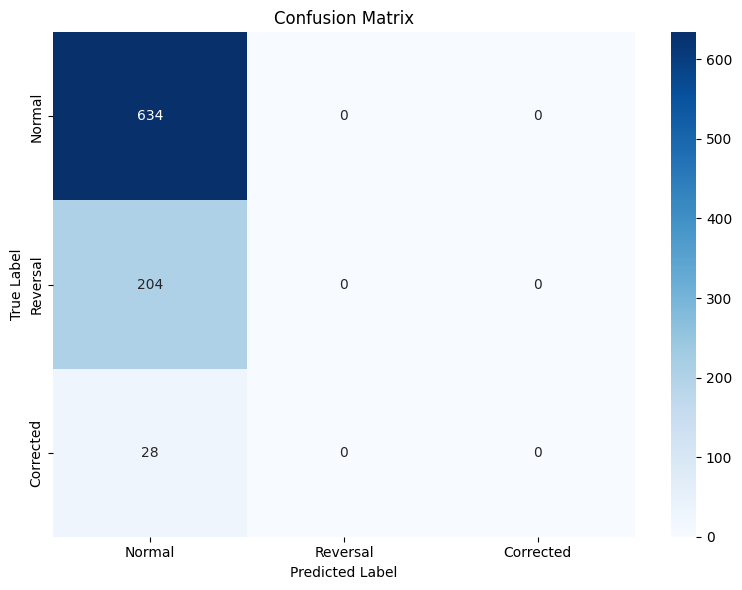

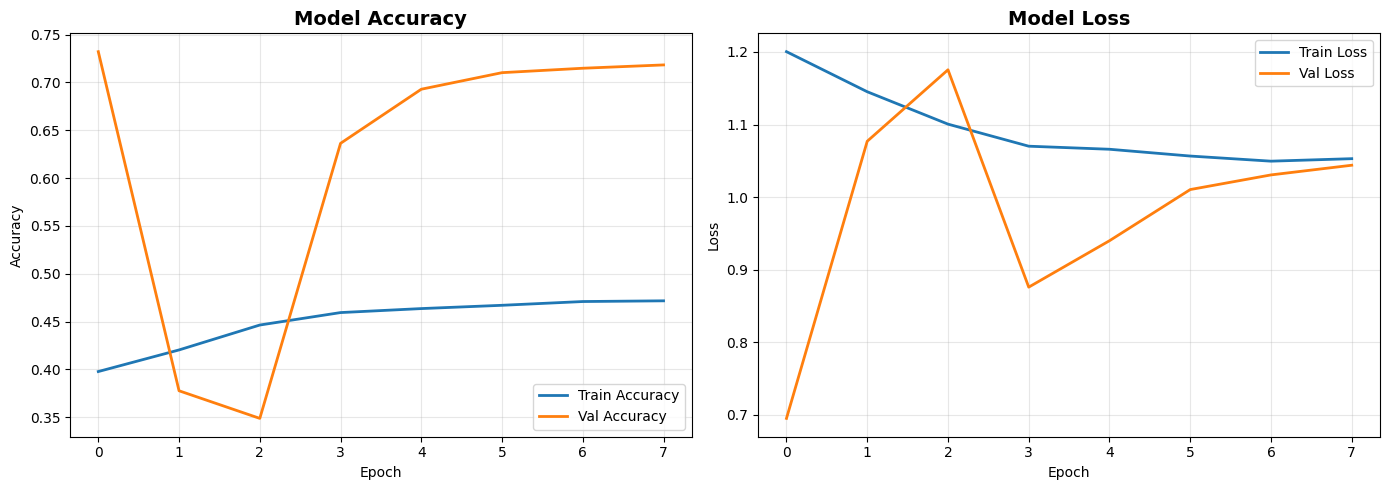

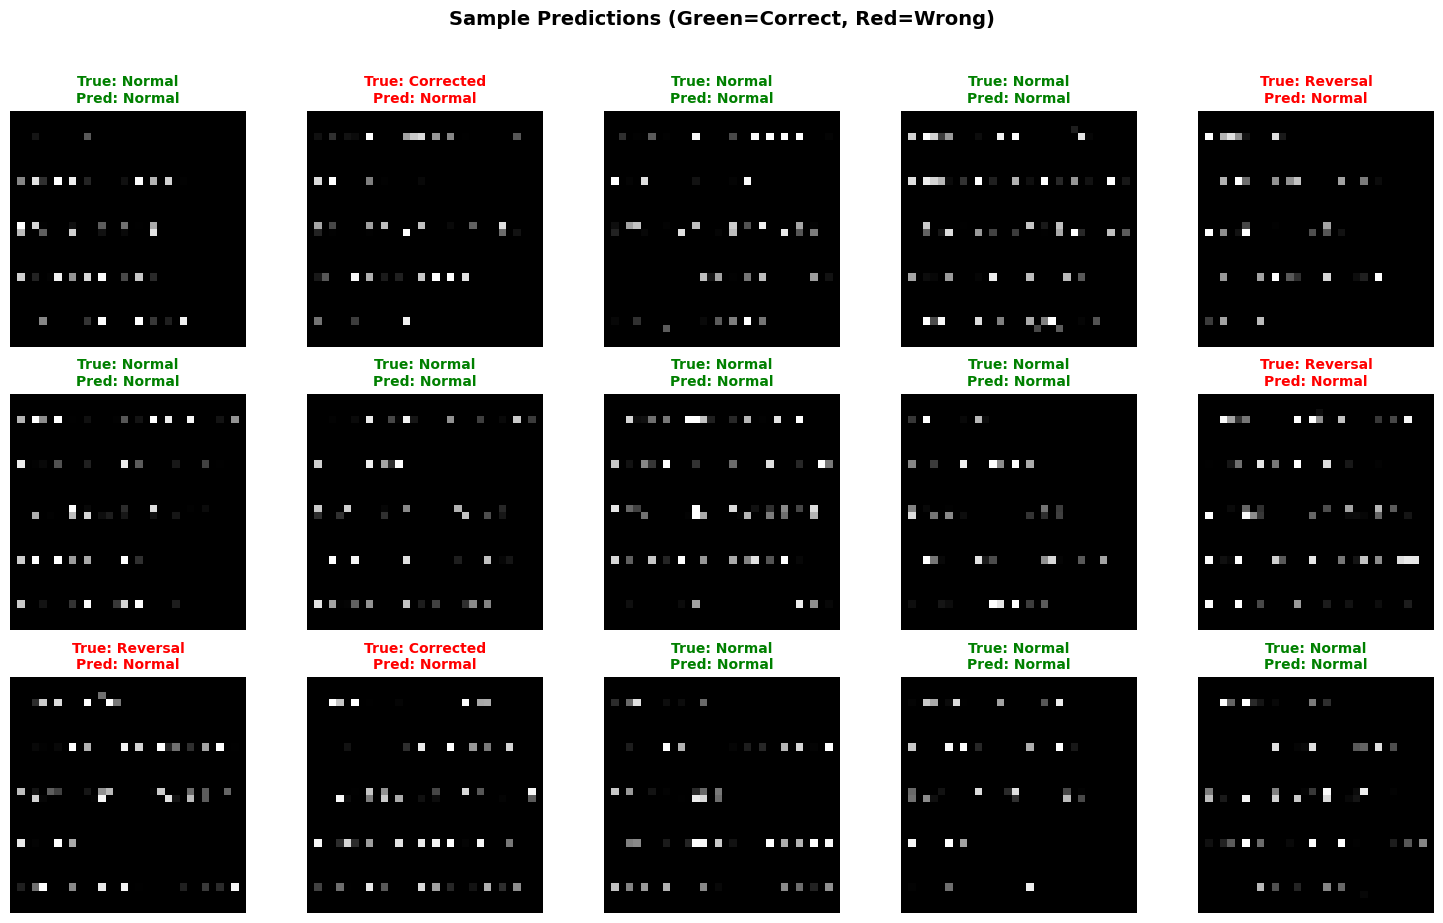


SAVING MODEL
Model saved as: dyslexia_cnn_model.h5



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TRAINING COMPLETE!
Final Validation Accuracy: 73.21 %
Target: 85-90% | Status: Keep tuning...


In [ ]:
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

# Load best weights
model.load_weights('best_model.h5')

# Evaluate
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print("\nValidation Loss:", round(val_loss, 4))
print("Validation Accuracy:", round(val_accuracy*100, 2), "%")

# Predictions
y_pred = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_val, y_pred_classes, target_names=class_names))

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    mask = y_val == i
    if np.sum(mask) > 0:
        class_acc = accuracy_score(y_val[mask], y_pred_classes[mask])
        print("  " + class_name + ":", round(class_acc, 4))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Training history plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Sample predictions
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i in range(15):
    idx = np.random.randint(0, len(X_val))
    axes[i].imshow(X_val[idx].reshape(32, 32), cmap='gray')
    axes[i].axis('off')
    pred_label = class_names[y_pred_classes[idx]]
    true_label = class_names[y_val[idx]]
    color = 'green' if y_pred_classes[idx] == y_val[idx] else 'red'
    axes[i].set_title('True: ' + true_label + '\nPred: ' + pred_label,
                      color=color, fontsize=10, fontweight='bold')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# SECTION 7: SAVE & DOWNLOAD
# ============================================================================

print("\n" + "="*50)
print("SAVING MODEL")
print("="*50)

model.save('dyslexia_cnn_model.h5')
print("Model saved as: dyslexia_cnn_model.h5")

print("\nDownloading files...")
files.download('best_model.h5')
files.download('confusion_matrix.png')
files.download('training_history.png')
files.download('sample_predictions.png')
files.download('sample_dataset.png')

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print("Final Validation Accuracy:", round(val_accuracy*100, 2), "%")
status = "ACHIEVED!" if val_accuracy >= 0.85 else "Keep tuning..."
print("Target: 85-90% | Status:", status)
print("="*50)